<a href="https://colab.research.google.com/github/Khushi9898/Glaucoma-Detection/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glaucoma Detection

## connecting to kaggle

In [1]:
import os

# Set Kaggle credentials as environment variables
os.environ["KAGGLE_USERNAME"] = "khushi0004"
os.environ["KAGGLE_KEY"] = "ce307d7827a9b6f9030f5105df62943b"

# Download the eyepac dataset from Kaggle
!kaggle datasets download -d deathtrooper/eyepacs-airogs-light

eyepacs-airogs-light.zip: Skipping, found more recently modified local copy (use --force to force download)


## loading libraries

In [2]:
pip install split-folders

In [3]:
pip install efficientnet_pytorch

In [4]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import splitfolders
from torchvision.datasets import ImageFolder
import zipfile
from efficientnet_pytorch import EfficientNet
from tqdm.auto import tqdm
from torchvision.transforms import Grayscale

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd '/content/drive/MyDrive/PyTorch'

/content/drive/MyDrive/PyTorch


In [8]:
from torchvision import transforms
# Define transformations, including converting to grayscale
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 1 channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust mean and std for 1-channel grayscale
])

In [9]:
# Path to the root directory of your train and test data in Google Drive
train_data_path = '/content/drive/MyDrive/PyTorch/train'
test_data_path = "/content/drive/MyDrive/PyTorch/test"

In [10]:
# List of eye states
diseases = ['normal', 'glaucoma']

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import os

class EyePACDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = ["normal", "glaucoma"]
        self.class_to_index = {"normal": 0, "glaucoma": 1}
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            class_path = os.path.join(root, cls)

            # Check if class_path is a directory
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.image_paths.append(os.path.join(class_path, filename))
                        self.labels.append(self.class_to_index[cls])
            else:
                print(f"Warning: {class_path} is not a directory.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Load custom train and test datasets
train_dataset = EyePACDataset(train_data_path, transform=transform)
test_dataset = EyePACDataset(test_data_path, transform=transform)

In [13]:
print(len(train_dataset))

1010


In [14]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
len(train_dataloader) , len(test_dataloader)

(32, 7)

In [16]:
len(train_dataset) , len(test_dataset)

(1010, 200)

In [17]:
# see the first training example
image , label = train_dataset[0]
image , label

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179,

In [18]:
class_names=diseases
class_names

['normal', 'glaucoma']

In [19]:
# Check the shape
print(f"image shape : {image.shape}")
print(f"image label : {class_names[label]}")

image shape : torch.Size([3, 224, 224])
image label : normal


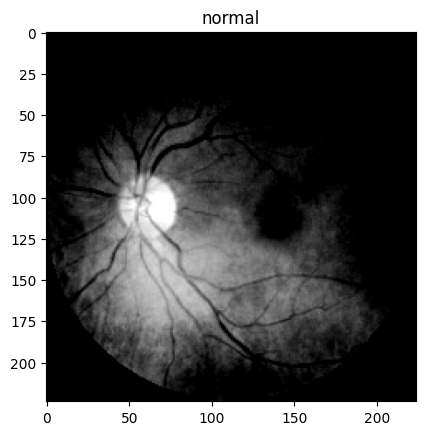

In [20]:
# Assuming your image is in the shape (3, 224, 224)
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title(diseases[label])
plt.show()

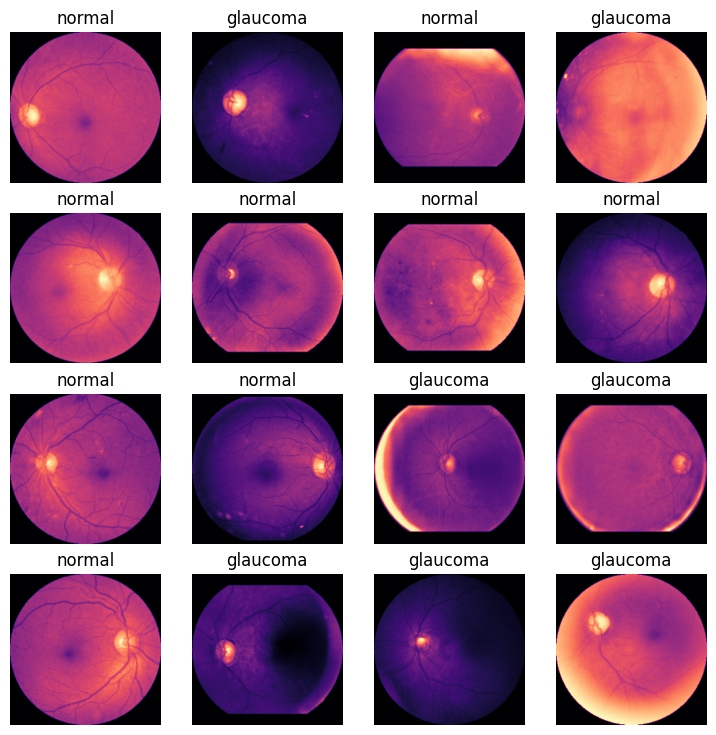

In [21]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

transform = Grayscale(num_output_channels=1)

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]

    img = transform(img)

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='magma')
    plt.title(diseases[label])
    plt.axis(False)

plt.show()


In [22]:
# Lets check out what we have created
batch_size=32
print(f"dataloaders : {train_dataloader , test_dataloader}")

dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x7a769e86ff40>, <torch.utils.data.dataloader.DataLoader object at 0x7a77715f5210>)


In [23]:
print(f"Number of batches available for training: {len(train_dataloader)}")

Number of batches available for training: 32


In [24]:
# Check out whats inside the training dataloader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## importing models

In [25]:
import torchvision.models as models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [26]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions already exist")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f :
    f.write(request.content)

helper_functions already exist


In [27]:
from timeit import default_timer as timer

def print_train_time(start:float,
                     end:float,
                     device:torch.device = None):
  """print difference between start and end time """
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [28]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device=device):
  """ Returns a dictionary containing the results of model predicting data loader"""
  loss , acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):

      # Make data device agnostic
      X , y = X.to(device) , y.to(device)
      # Make predictions
      y_pred = model(X)

      #Accumulate the loss and accuracy per batch
      loss += loss_fn(y_pred,y)
      acc+= accuracy_fn(y_true = y,
                        y_pred = y_pred.argmax(dim=1))
    # Scale the loss and acc to find the average loss/ acc per batch
    loss/= len(data_loader)
    acc/= len(data_loader)

  return {"model_name" : model.__class__.__name__, # only works when model was created with a class
          "model_loss" : loss.item(),
          "model_acc" :acc}

In [29]:
def train_step(model:torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """ performs a training with model trying to learn on data_loader."""
  train_loss,train_acc = 0,0
  # Put model into training mode
  model.train()

  # Add a loop through the training batches
  for batch ,(X,y) in enumerate(data_loader):
    # put data on target device
    X,y= X.to(device) , y.to(device)

    #1. forward pass(outputs ths raw logits)
    y_pred = model(X)

    #2. calculate the loss (per batch)
    loss = loss_fn(y_pred,y)
    train_loss +=loss # accumulate train loss

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    #5. optimzier step
    optimizer.step()

    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim=1)) # go from raw logits -> prediction labels


  # Device total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | Train Acc : {train_acc:.2f}% ")
  return train_loss , train_acc

In [30]:
def test_step(model:torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):
  """ performs a testing loop step on model going over data_loader"""
  test_loss , test_acc=0,0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X,y in data_loader:
      # send the data to the target device
      X,y= X.to(device) , y.to(device)

      #1. forward pass
      test_pred = model(X)

      #2. Calculate the loss / acc
      test_loss += loss_fn(test_pred,y)
      test_acc+= accuracy_fn(y_true = y,y_pred = test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}% ")
    return test_loss , test_acc

# ResNet50

## loading ResNet50 model

In [46]:
# Resnet50 -- Loading Model
resnet50_model = models.resnet50(pretrained=True)
print(resnet50_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## setting up loss function,optimizer and accuracy metrics

In [47]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = resnet50_model.parameters(),
                            lr = 0.001)


## Training on model

In [48]:
# Modify the model's final layers
num_classes = len(class_names)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)  # Modify the last fully connected layer

torch.manual_seed(100)

# measure time
from timeit import default_timer as timer
train_time_start1 = timer()

# Training loop
resnet50_model.to(device)

# Setting epochs
epochs = 10

results_resnet50 = {"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_loss , train_acc = train_step(model = resnet50_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_loss , test_acc = test_step(model=resnet50_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
  results_resnet50["train_loss"].append(train_loss)
  results_resnet50["train_acc"].append(train_acc)
  results_resnet50["test_loss"].append(test_loss)
  results_resnet50["test_acc"].append(test_acc)
train_time_end1 = timer()
total_train_time_model_1 = print_train_time(start = train_time_start1,
                                              end = train_time_end1,
                                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 0.70931 | Train Acc : 61.83% 
Test loss : 2.64670 | Test Acc : 68.30% 
Epoch : 1
----------
Train loss : 0.59762 | Train Acc : 66.63% 
Test loss : 3.12881 | Test Acc : 64.73% 
Epoch : 2
----------
Train loss : 0.50947 | Train Acc : 75.65% 
Test loss : 0.64302 | Test Acc : 72.32% 
Epoch : 3
----------
Train loss : 0.44813 | Train Acc : 78.67% 
Test loss : 4.07200 | Test Acc : 47.32% 
Epoch : 4
----------
Train loss : 0.42589 | Train Acc : 81.87% 
Test loss : 0.90688 | Test Acc : 59.82% 
Epoch : 5
----------
Train loss : 0.39506 | Train Acc : 82.43% 
Test loss : 0.44600 | Test Acc : 81.70% 
Epoch : 6
----------
Train loss : 0.28348 | Train Acc : 88.73% 
Test loss : 0.92467 | Test Acc : 79.02% 
Epoch : 7
----------
Train loss : 0.26012 | Train Acc : 88.72% 
Test loss : 0.48569 | Test Acc : 80.36% 
Epoch : 8
----------
Train loss : 0.23320 | Train Acc : 90.71% 
Test loss : 1.01007 | Test Acc : 55.80% 
Epoch : 9
----------
Train loss : 0.22212 | Train Acc :

In [49]:
# Get model_1_results
model_1_results = eval_model(model=resnet50_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/7 [00:00<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.431983083486557,
 'model_acc': 86.16071428571429}

## saving ResNet50

In [50]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Glaucoma_Detection")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "ResNet50.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = resnet50_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Glaucoma_Detection/ResNet50.pth


# AlexNet

## loading Alexnet model

In [31]:
alexnet_model = models.alexnet(pretrained=True)
print(alexnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## setting up loss function ,optimizer and accuracy metrics

In [32]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = alexnet_model.parameters(),
                            lr = 0.001)

## Training on model

In [33]:
# Modify the model's final layers
num_classes = len(class_names)  # Replace with the number of your output classes
alexnet_model.classifier[6] = nn.Linear(4096, num_classes)

torch.manual_seed(100)

# measure time
from timeit import default_timer as timer
train_time_start2 = timer()

# Training loop
alexnet_model.to(device)

# Setting epochs
epochs = 10

results_alexnet = {"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_loss , train_acc = train_step(model = alexnet_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_loss , test_acc = test_step(model=alexnet_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
  results_alexnet["train_loss"].append(train_loss)
  results_alexnet["train_acc"].append(train_acc)
  results_alexnet["test_loss"].append(test_loss)
  results_alexnet["test_acc"].append(test_acc)
train_time_end2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start2,
                                              end = train_time_end2,
                                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 1.02971 | Train Acc : 48.63% 
Test loss : 0.69992 | Test Acc : 44.64% 
Epoch : 1
----------
Train loss : 0.69568 | Train Acc : 51.53% 
Test loss : 0.70978 | Test Acc : 44.64% 
Epoch : 2
----------
Train loss : 0.70008 | Train Acc : 47.60% 
Test loss : 0.71057 | Test Acc : 44.64% 
Epoch : 3
----------
Train loss : 0.69501 | Train Acc : 49.29% 
Test loss : 0.68747 | Test Acc : 55.36% 
Epoch : 4
----------
Train loss : 0.69647 | Train Acc : 51.42% 
Test loss : 0.69851 | Test Acc : 44.64% 
Epoch : 5
----------
Train loss : 0.69571 | Train Acc : 48.36% 
Test loss : 0.69010 | Test Acc : 55.36% 
Epoch : 6
----------
Train loss : 0.70250 | Train Acc : 45.48% 
Test loss : 0.70489 | Test Acc : 44.64% 
Epoch : 7
----------
Train loss : 0.69716 | Train Acc : 52.01% 
Test loss : 0.69348 | Test Acc : 44.64% 
Epoch : 8
----------
Train loss : 0.69758 | Train Acc : 48.90% 
Test loss : 0.69600 | Test Acc : 44.64% 
Epoch : 9
----------
Train loss : 0.69518 | Train Acc :

In [34]:
# Get model_2_results
model_2_results = eval_model(model=alexnet_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_2_results

  0%|          | 0/7 [00:00<?, ?it/s]

{'model_name': 'AlexNet',
 'model_loss': 0.7046844363212585,
 'model_acc': 44.642857142857146}

## saving the model

In [35]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Glaucoma_Detection")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "alexnet.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = alexnet_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Glaucoma_Detection/alexnet.pth


# GoogleNet

## loading GoogleNet model

In [36]:
googlenet_model = models.googlenet(pretrained=True)
print(googlenet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 63.0MB/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## setting up loss function,optimizer and accuracy metrics

In [37]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = googlenet_model.parameters(),
                            lr = 0.001)

## Training on model

In [38]:
# Modify the model's final layers
num_classes = len(class_names)  # Replace with the number of your output classes
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)

torch.manual_seed(100)

# measure time
from timeit import default_timer as timer
train_time_start3 = timer()

# Training loop
googlenet_model.to(device)

# Setting epochs
epochs = 10

results_googlenet = {"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_loss , train_acc = train_step(model = googlenet_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_loss , test_acc = test_step(model=googlenet_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
  results_googlenet["train_loss"].append(train_loss)
  results_googlenet["train_acc"].append(train_acc)
  results_googlenet["test_loss"].append(test_loss)
  results_googlenet["test_acc"].append(test_acc)
train_time_end3 = timer()
total_train_time_model_3 = print_train_time(start = train_time_start3,
                                              end = train_time_end3,
                                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 0.57810 | Train Acc : 70.01% 
Test loss : 0.82300 | Test Acc : 74.11% 
Epoch : 1
----------
Train loss : 0.39328 | Train Acc : 83.83% 
Test loss : 0.55744 | Test Acc : 79.46% 
Epoch : 2
----------
Train loss : 0.29079 | Train Acc : 87.93% 
Test loss : 0.52037 | Test Acc : 79.46% 
Epoch : 3
----------
Train loss : 0.19458 | Train Acc : 92.58% 
Test loss : 0.72821 | Test Acc : 74.55% 
Epoch : 4
----------
Train loss : 0.16081 | Train Acc : 93.47% 
Test loss : 1.44041 | Test Acc : 65.62% 
Epoch : 5
----------
Train loss : 0.18562 | Train Acc : 92.06% 
Test loss : 0.38398 | Test Acc : 85.27% 
Epoch : 6
----------
Train loss : 0.15580 | Train Acc : 93.64% 
Test loss : 0.34869 | Test Acc : 86.61% 
Epoch : 7
----------
Train loss : 0.08449 | Train Acc : 97.27% 
Test loss : 0.47628 | Test Acc : 86.61% 
Epoch : 8
----------
Train loss : 0.08597 | Train Acc : 96.90% 
Test loss : 0.65367 | Test Acc : 85.71% 
Epoch : 9
----------
Train loss : 0.07772 | Train Acc :

In [39]:
# Get model_3_results
model_3_results = eval_model(model=googlenet_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_3_results

  0%|          | 0/7 [00:00<?, ?it/s]

{'model_name': 'GoogLeNet',
 'model_loss': 0.3779980540275574,
 'model_acc': 89.28571428571429}

## saving the model

In [40]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Glaucoma_Detection")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "googlenet.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = googlenet_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Glaucoma_Detection/googlenet.pth


# VGG16

## loading VGG16 model

In [41]:
vgg16_model = models.vgg16(pretrained=True)
print(vgg16_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## setting up loss function ,optimizer and accuracy metrics

In [42]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vgg16_model.parameters(),
                            lr = 0.001)

## Training on model

In [43]:
# Modify the model's final layers
num_classes = len(class_names)  # Replace with the number of your output classes
vgg16_model.classifier[6] = nn.Linear(4096, num_classes)

torch.manual_seed(100)

# measure time
from timeit import default_timer as timer
train_time_start4 = timer()

# Training loop
vgg16_model.to(device)

# Setting epochs
epochs = 10

results_vgg16 = {"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----------")
  train_loss , train_acc = train_step(model = vgg16_model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_loss , test_acc = test_step(model=vgg16_model,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)
  results_vgg16["train_loss"].append(train_loss)
  results_vgg16["train_acc"].append(train_acc)
  results_vgg16["test_loss"].append(test_loss)
  results_vgg16["test_acc"].append(test_acc)
train_time_end4 = timer()
total_train_time_model_4 = print_train_time(start = train_time_start4,
                                              end = train_time_end4,
                                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
----------
Train loss : 1.73497 | Train Acc : 50.00% 
Test loss : 0.68409 | Test Acc : 55.36% 
Epoch : 1
----------
Train loss : 0.71403 | Train Acc : 49.28% 
Test loss : 0.73296 | Test Acc : 44.64% 
Epoch : 2
----------
Train loss : 0.69821 | Train Acc : 50.92% 
Test loss : 0.71141 | Test Acc : 44.64% 
Epoch : 3
----------
Train loss : 0.69323 | Train Acc : 50.66% 
Test loss : 0.68835 | Test Acc : 55.36% 
Epoch : 4
----------
Train loss : 0.69317 | Train Acc : 51.65% 
Test loss : 0.70661 | Test Acc : 44.64% 
Epoch : 5
----------
Train loss : 0.69572 | Train Acc : 49.71% 
Test loss : 0.69165 | Test Acc : 55.36% 
Epoch : 6
----------
Train loss : 0.69782 | Train Acc : 47.06% 
Test loss : 0.70296 | Test Acc : 44.64% 
Epoch : 7
----------
Train loss : 0.70009 | Train Acc : 49.46% 
Test loss : 0.70293 | Test Acc : 44.64% 
Epoch : 8
----------
Train loss : 0.69695 | Train Acc : 48.72% 
Test loss : 0.69699 | Test Acc : 44.64% 
Epoch : 9
----------
Train loss : 0.69734 | Train Acc :

In [44]:
# Get model_4_results
model_4_results = eval_model(model=vgg16_model,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device)
model_4_results

  0%|          | 0/7 [00:00<?, ?it/s]

{'model_name': 'VGG',
 'model_loss': 0.7032265067100525,
 'model_acc': 44.642857142857146}

## saving the model

In [45]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path("Glaucoma_Detection")
MODEL_PATH.mkdir(parents = True ,
                 exist_ok = True)

# Create a save model
MODEL_NAME = "vgg16.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = vgg16_model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : Glaucoma_Detection/vgg16.pth


# comparison

In [53]:
# see if required packages are installed and ifnot , install them ..
try:
  import torchmetrics , mlxtend
  print(f",mlxtend version : {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]>=19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  print(f"mlxtend version : {mlxtend.__version__}")

,mlxtend version : 0.23.0
mlxtend version : 0.23.0


In [52]:
import mlxtend
print(mlxtend.__version__)

0.23.0


In [54]:
import torch

# Initialize an empty list to store the target labels
test_labels = []

# Loop through the test DataLoader to get labels
for images, labels in test_dataloader:
    test_labels.extend(labels.tolist())  # Assuming labels are in tensor format

# Convert the list of labels into a PyTorch tensor
test_labels_tensor = torch.tensor(test_labels)

# Now, test_labels_tensor contains the target labels for the test dataset as a tensor
print(test_labels_tensor)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


## ResNet50

In [55]:
from tqdm.auto import tqdm
torch.manual_seed(100)
#1 . make predictions
y_preds = []
resnet50_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = resnet50_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor1 = torch.cat(y_preds)
y_pred_tensor1

making predictions .....:   0%|          | 0/7 [00:00<?, ?it/s]

tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1])

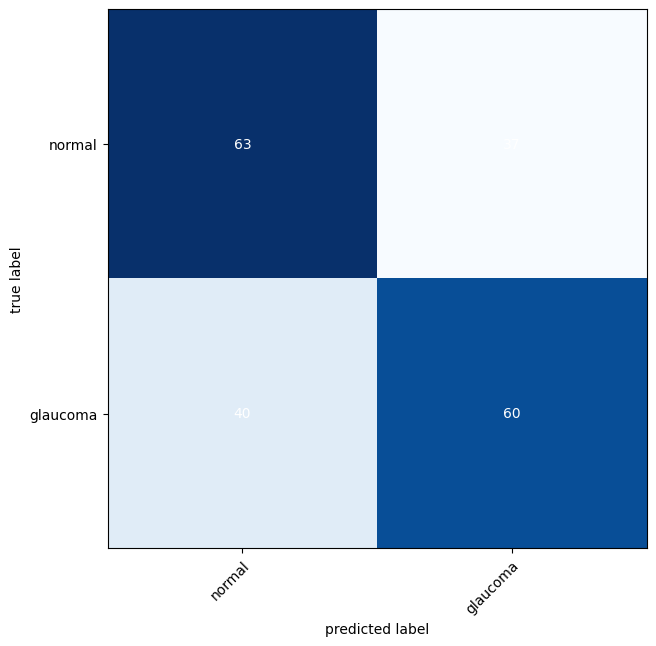

In [56]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
torch.manual_seed(100)

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(diseases),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor1,
                         target = test_labels_tensor)

# Extract the confusion matrix values as a numpy array
confmat_np = confmat_tensor.numpy()

accuracy_1 = np.trace(confmat_np) / np.sum(confmat_np)

# Micro-averaging (overall precision, recall, and F1)
micro_precision_1 = precision_score(test_labels_tensor, y_pred_tensor1, average='weighted')
micro_recall_1 = recall_score(test_labels_tensor, y_pred_tensor1, average='weighted')
micro_f1_1 = f1_score(test_labels_tensor, y_pred_tensor1, average='weighted')


# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## AlexNet

In [57]:
from tqdm.auto import tqdm
torch.manual_seed(100)
#1 . make predictions
y_preds = []
alexnet_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = alexnet_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor2 = torch.cat(y_preds)
y_pred_tensor2

making predictions .....:   0%|          | 0/7 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


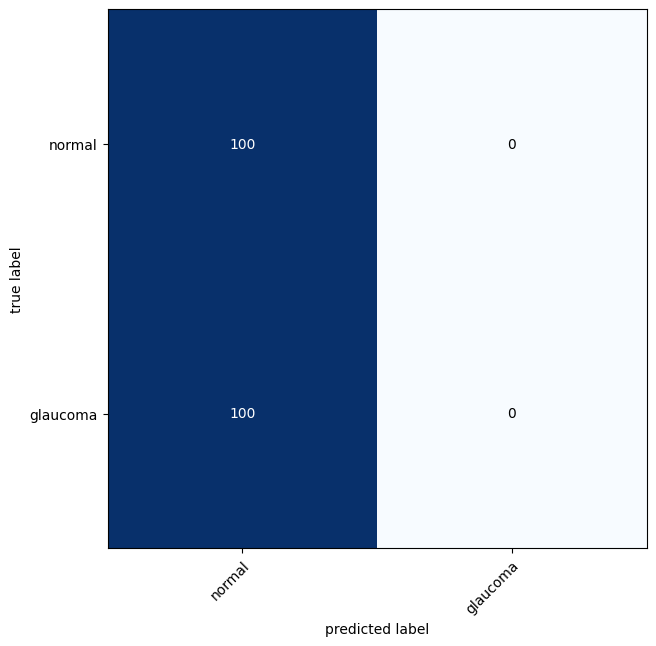

In [58]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
torch.manual_seed(100)

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(diseases),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor2,
                         target = test_labels_tensor)

# Extract the confusion matrix values as a numpy array
confmat_np = confmat_tensor.numpy()

accuracy_2 = np.trace(confmat_np) / np.sum(confmat_np)

# Micro-averaging (overall precision, recall, and F1)
micro_precision_2 = precision_score(test_labels_tensor, y_pred_tensor2, average='weighted')
micro_recall_2 = recall_score(test_labels_tensor, y_pred_tensor2, average='weighted')
micro_f1_2 = f1_score(test_labels_tensor, y_pred_tensor2, average='weighted')


# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## GoogleNet

In [59]:
from tqdm.auto import tqdm
torch.manual_seed(100)
#1 . make predictions
y_preds = []
googlenet_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = googlenet_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor3 = torch.cat(y_preds)
y_pred_tensor3

making predictions .....:   0%|          | 0/7 [00:00<?, ?it/s]

tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1])

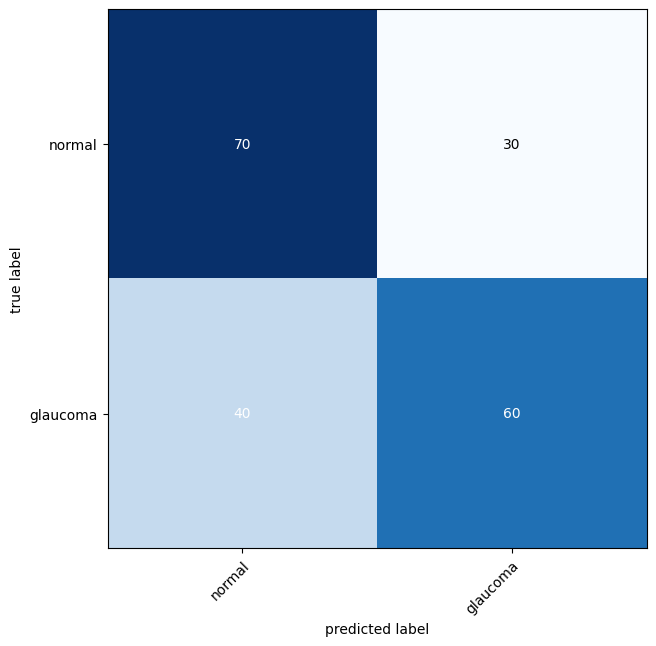

In [60]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
torch.manual_seed(100)

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(diseases),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor3,
                         target = test_labels_tensor)

# Extract the confusion matrix values as a numpy array
confmat_np = confmat_tensor.numpy()

accuracy_3 = np.trace(confmat_np) / np.sum(confmat_np)

# Micro-averaging (overall precision, recall, and F1)
micro_precision_3 = precision_score(test_labels_tensor, y_pred_tensor3, average='weighted')
micro_recall_3 = recall_score(test_labels_tensor, y_pred_tensor3, average='weighted')
micro_f1_3 = f1_score(test_labels_tensor, y_pred_tensor3, average='weighted')


# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

## VGG16

In [61]:
from tqdm.auto import tqdm
torch.manual_seed(100)
#4 . make predictions
y_preds = []
# Move the model to the same device
vgg16_model.to(device)
vgg16_model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader , desc = "making predictions ....."):
    # send data to target device
    X , y = X.to(device) , y.to(device)
    # do forward pass
    y_logit = vgg16_model(X)
    # Turn predictions from logits -> prediction probs -> pred labels
    y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
    # put prediction on cpu for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate
y_pred_tensor4 = torch.cat(y_preds)
y_pred_tensor4

making predictions .....:   0%|          | 0/7 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


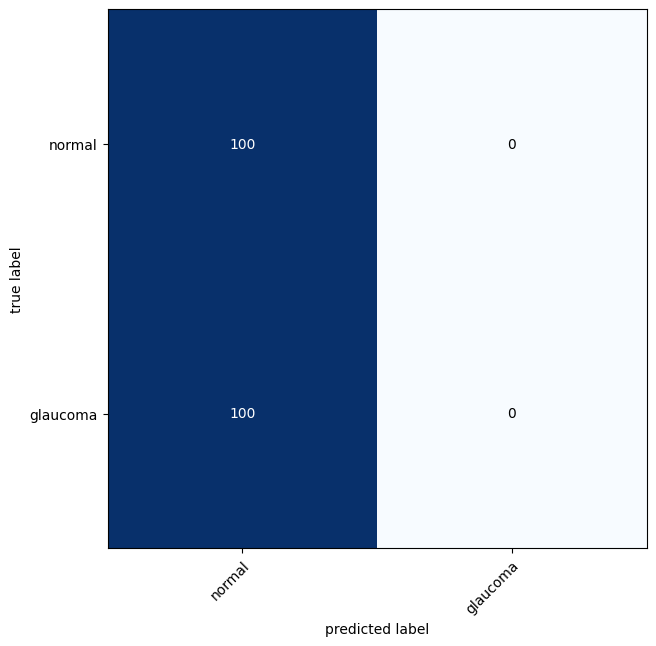

In [62]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
torch.manual_seed(100)

# 2. setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes = len(diseases),task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor4,
                         target = test_labels_tensor)

# Extract the confusion matrix values as a numpy array
confmat_np = confmat_tensor.numpy()

accuracy_4 = np.trace(confmat_np) / np.sum(confmat_np)

# Micro-averaging (overall precision, recall, and F1)
micro_precision_4 = precision_score(test_labels_tensor, y_pred_tensor4, average='weighted')
micro_recall_4 = recall_score(test_labels_tensor, y_pred_tensor4, average='weighted')
micro_f1_4 = f1_score(test_labels_tensor, y_pred_tensor4, average='weighted')


# 3. Plot confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10,7)
)

In [63]:
import pandas as pd
compare_results = pd.DataFrame([model_1_results,
                               model_2_results,
                               model_3_results,
                                model_4_results])

# Reset the index of the resulting DataFrame
compare_results.reset_index(drop=True, inplace=True)

# Remove the "loss" column
compare_results = compare_results.drop(columns="model_loss")

compare_results["Accuracy"] =[accuracy_1,accuracy_2,accuracy_3,accuracy_4]
compare_results["Precision"] =[micro_precision_1,micro_precision_2,micro_precision_3,micro_precision_4]
compare_results["Recall"] =[micro_recall_1,micro_recall_2,micro_recall_3,micro_recall_4]
compare_results["F1 Score"] =[micro_f1_1,micro_f1_2,micro_f1_3,micro_f1_4]


compare_results

,model_name,model_acc,Accuracy,Precision,Recall,F1 Score
0,ResNet,86.160714,0.615,0.615104,0.615,0.614913
1,AlexNet,44.642857,0.500,0.250000,0.500,0.333333
2,GoogLeNet,89.285714,0.650,0.651515,0.650,0.649123
3,VGG,44.642857,0.500,0.250000,0.500,0.333333


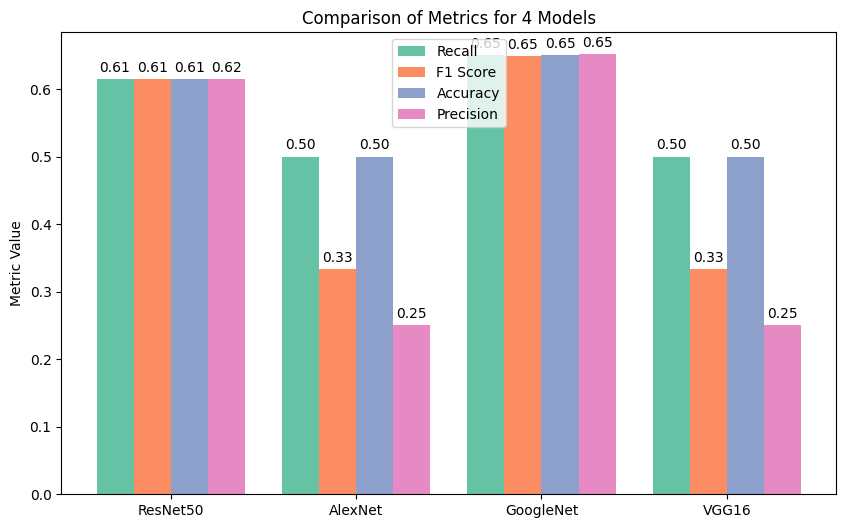

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Model names and metric names
model_names = ['ResNet50','AlexNet','GoogleNet','VGG16']
metric_names = ['Recall', 'F1 Score', 'Accuracy', 'Precision']

# Metric values for each model
values = np.array([
    [micro_recall_1, micro_f1_1, accuracy_1, micro_precision_1],
    [micro_recall_2, micro_f1_2, accuracy_2, micro_precision_2],
    [micro_recall_3, micro_f1_3, accuracy_3, micro_precision_3],
    [micro_recall_4, micro_f1_4, accuracy_4, micro_precision_4]
])

# Define bar width
bar_width = 0.2
index = np.arange(len(model_names))

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Use Seaborn's "viridis" color palette for distinct colors
palette = sns.color_palette("Set2")

for i, metric_name in enumerate(metric_names):
    bars = ax.bar(index + i * bar_width, values[:, i], bar_width, label=metric_name, color=palette[i])
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the value to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position to annotate
                    xytext=(0, 3),  # Offset to adjust the text position
                    textcoords="offset points",
                    ha='center', va='bottom')

# Set the x-axis labels
ax.set_xticks(index + bar_width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(model_names)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the chart title
ax.set_title('Comparison of Metrics for 4 Models')

# Adjust the legend location
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

# Show the grouped bar chart
plt.show()

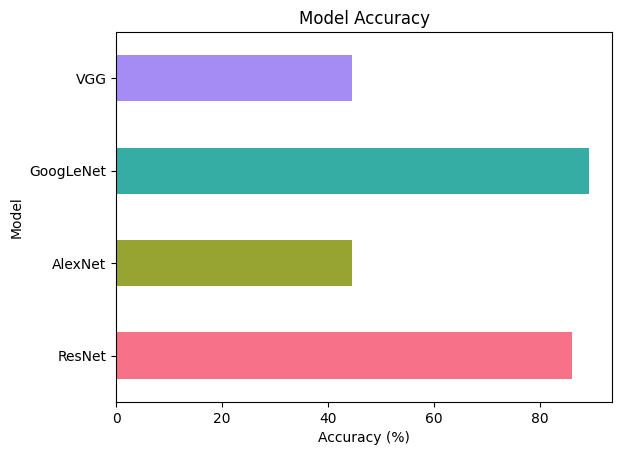

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette using Seaborn
palette = sns.color_palette("husl", len(compare_results))

# Assuming you have a DataFrame called compare_results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh", color=palette)

plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()

# Loss and Accuracy Curves

In [66]:
from typing import Dict, List

In [67]:
def plot_loss_curves(results : Dict[str,List[float]]):
  """ Plots training curvesof a results dictionary"""

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # count epochs
  epochs = range(len(results["train_loss"]))

  # plot
  plt.figure(figsize = (15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

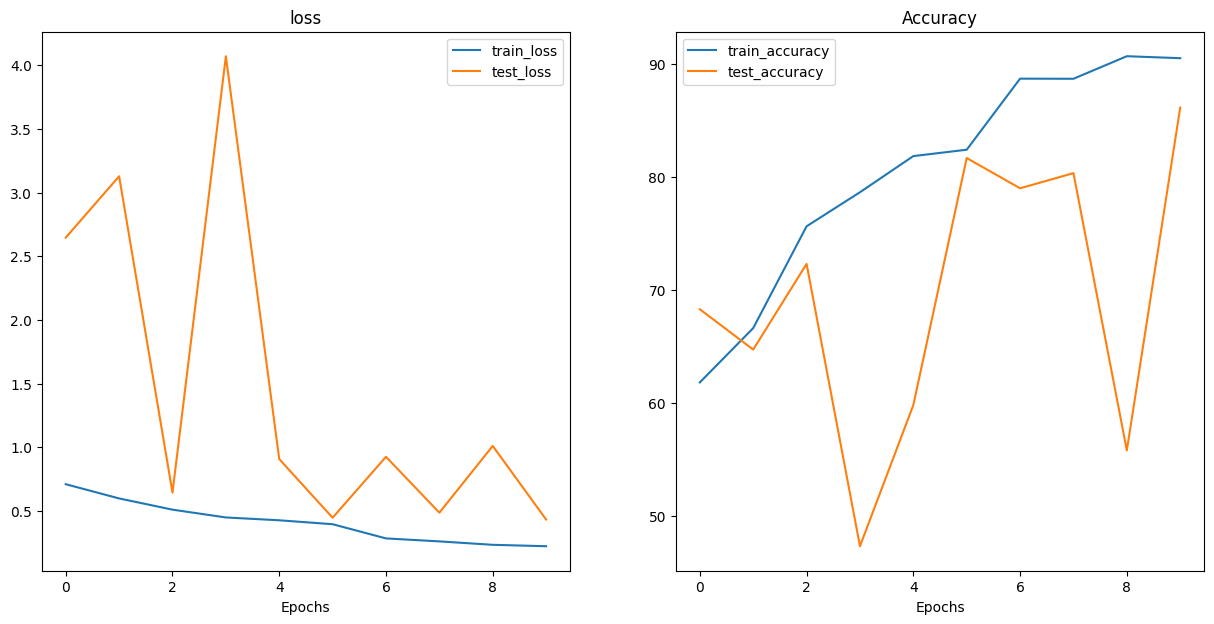

In [68]:
# After collecting training and testing metrics
import numpy as np

for key in results_resnet50:
    results_resnet50[key] = [value.cpu().detach().numpy() if isinstance(value, torch.Tensor) else value for value in results_resnet50[key]]

# Plot the loss and accuracy curves
plot_loss_curves(results_resnet50)

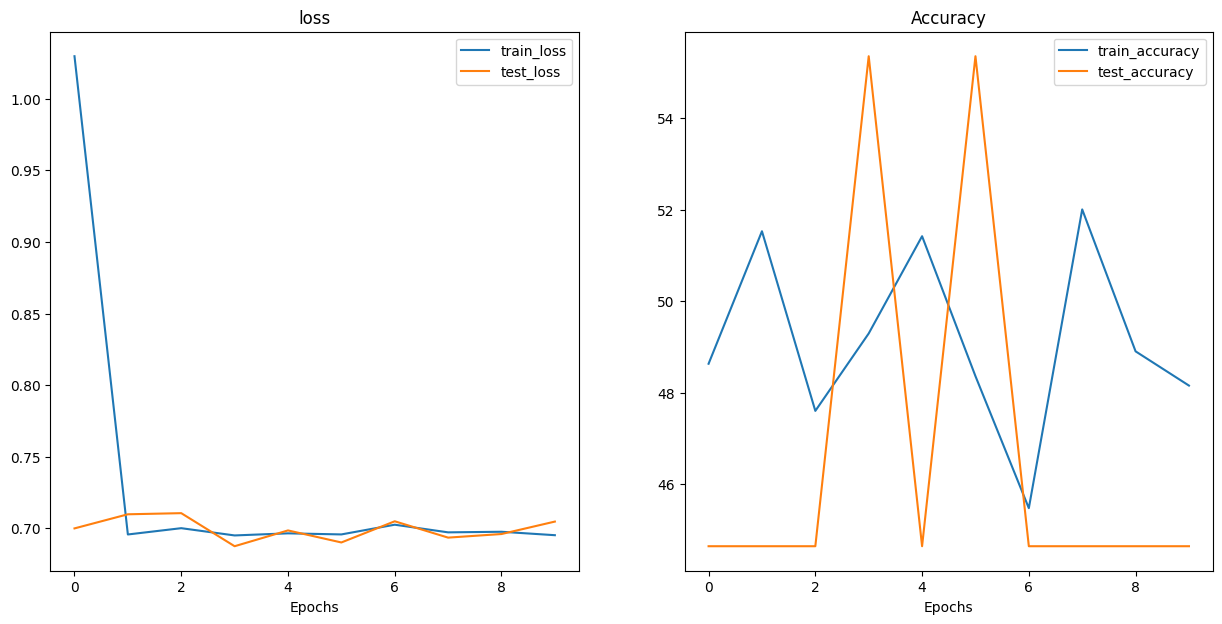

In [69]:
# After collecting training and testing metrics
import numpy as np

for key in results_alexnet:
    results_alexnet[key] = [value.cpu().detach().numpy() if isinstance(value, torch.Tensor) else value for value in results_alexnet[key]]

# Plot the loss and accuracy curves
plot_loss_curves(results_alexnet)

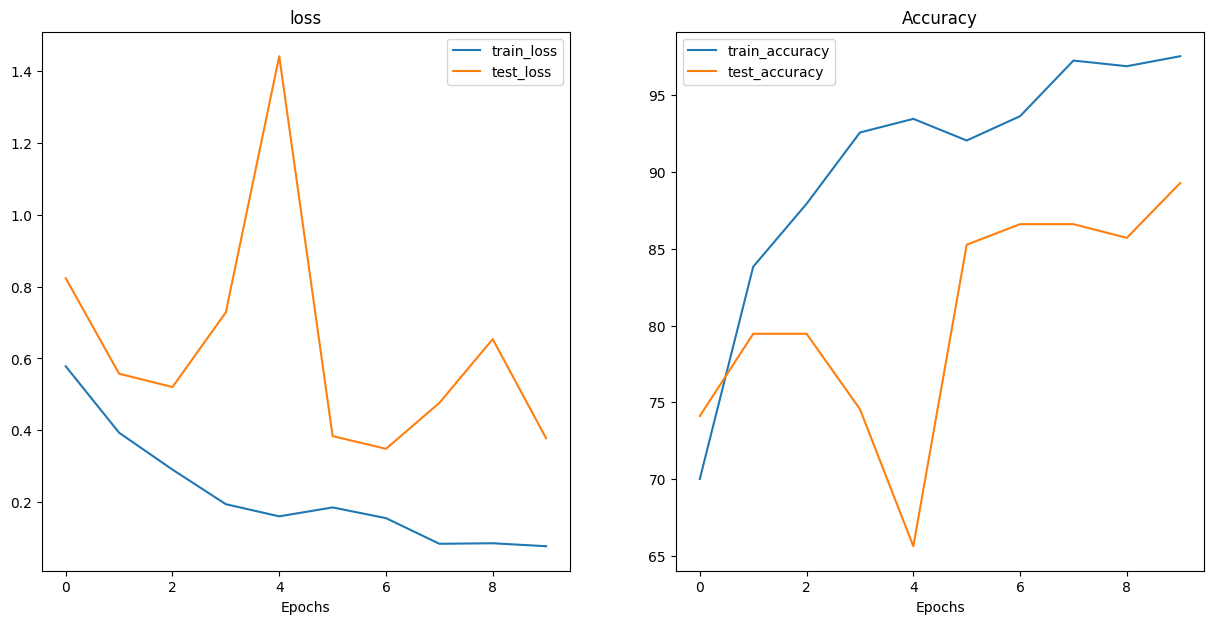

In [70]:
# After collecting training and testing metrics
import numpy as np

for key in results_googlenet:
    results_googlenet[key] = [value.cpu().detach().numpy() if isinstance(value, torch.Tensor) else value for value in results_googlenet[key]]

# Plot the loss and accuracy curves
plot_loss_curves(results_googlenet)

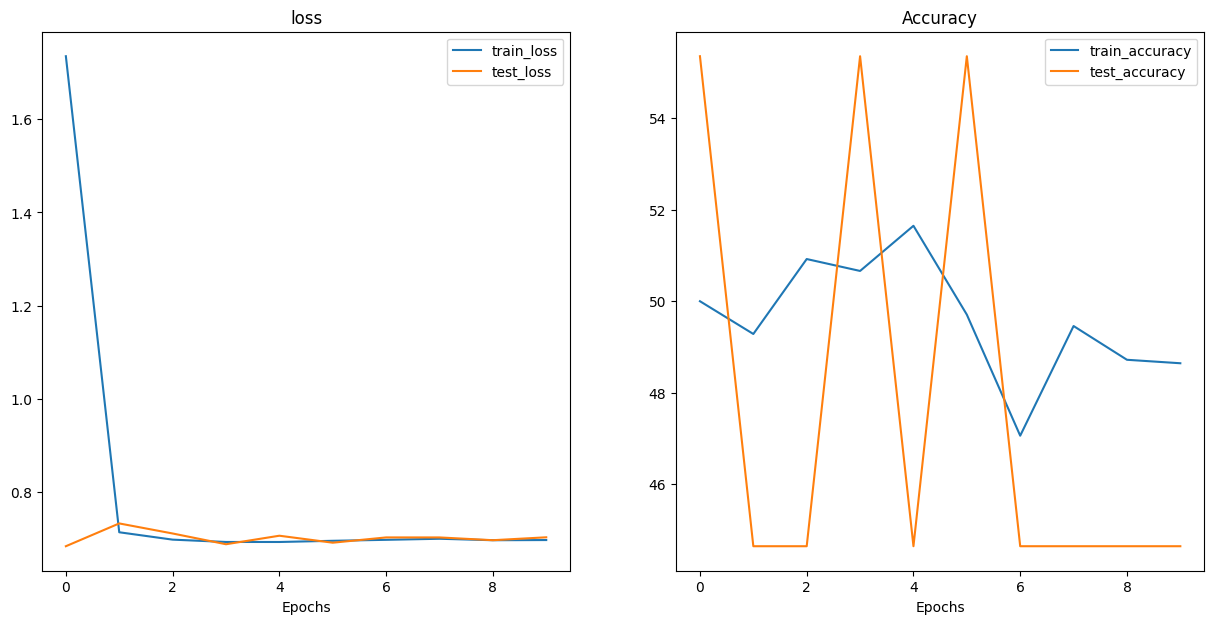

In [71]:
# After collecting training and testing metrics
import numpy as np

for key in results_vgg16:
    results_vgg16[key] = [value.cpu().detach().numpy() if isinstance(value, torch.Tensor) else value for value in results_vgg16[key]]

# Plot the loss and accuracy curves
plot_loss_curves(results_vgg16)

In [72]:
import pandas as pd

model_alexnet_df = pd.DataFrame(results_alexnet)
model_vgg16_df = pd.DataFrame(results_vgg16)
model_resnet50_df = pd.DataFrame(results_resnet50)
model_googlenet_df = pd.DataFrame(results_googlenet)


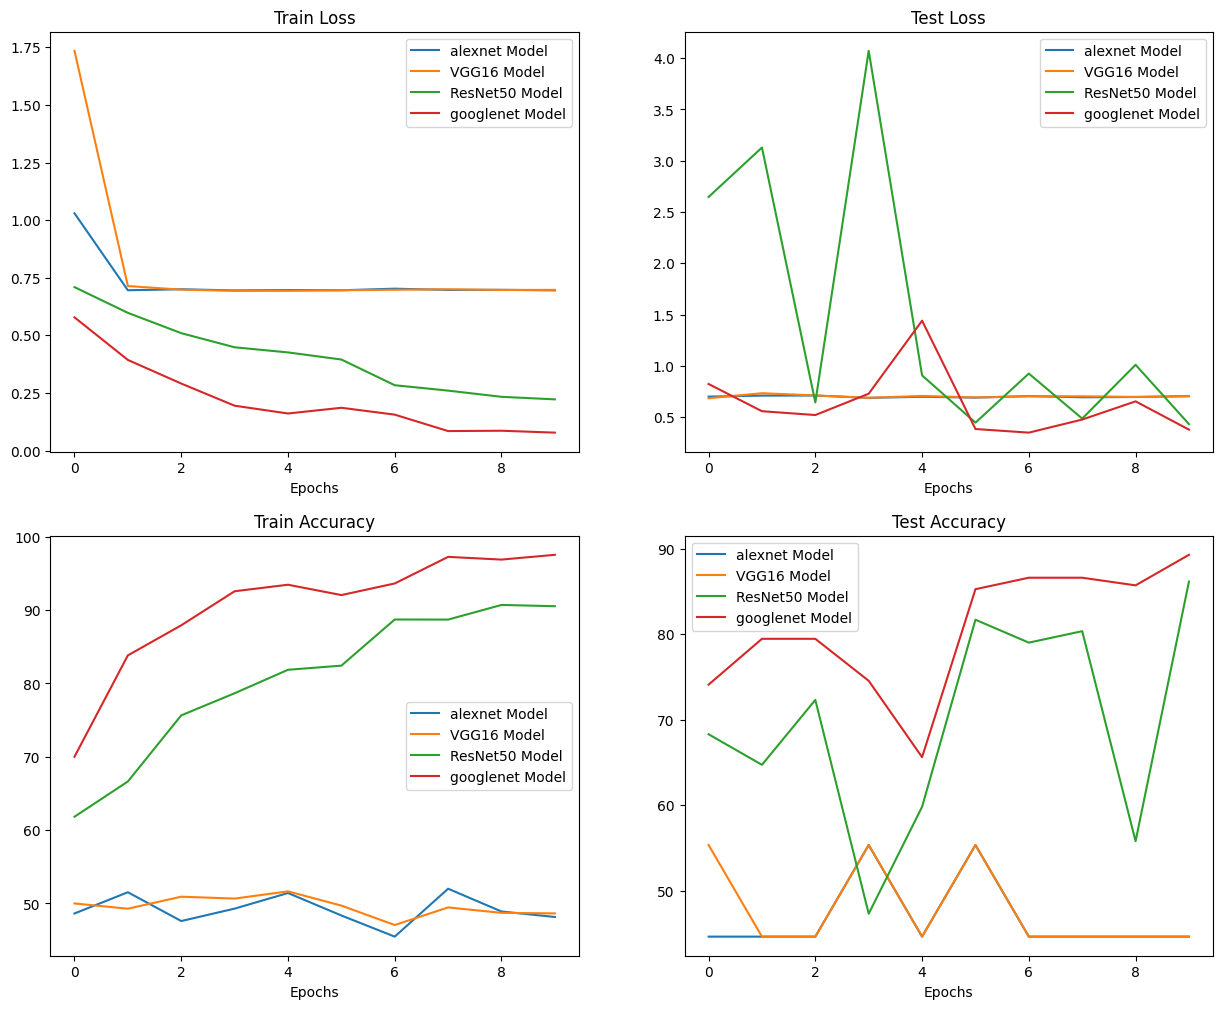

In [73]:
# SetUp a plot

plt.figure(figsize=(15,12))

# get epochs
epochs = range(len(model_resnet50_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_alexnet_df["train_loss"],label="alexnet Model")
plt.plot(epochs,model_vgg16_df["train_loss"],label="VGG16 Model")
plt.plot(epochs,model_resnet50_df["train_loss"],label="ResNet50 Model")
plt.plot(epochs,model_googlenet_df["train_loss"],label="googlenet Model")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_alexnet_df["test_loss"],label="alexnet Model")
plt.plot(epochs,model_vgg16_df["test_loss"],label="VGG16 Model")
plt.plot(epochs,model_resnet50_df["test_loss"],label="ResNet50 Model")
plt.plot(epochs,model_googlenet_df["test_loss"],label="googlenet Model")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs,model_alexnet_df["train_acc"],label="alexnet Model")
plt.plot(epochs,model_vgg16_df["train_acc"],label="VGG16 Model")
plt.plot(epochs,model_resnet50_df["train_acc"],label="ResNet50 Model")
plt.plot(epochs,model_googlenet_df["train_acc"],label="googlenet Model")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs,model_alexnet_df["test_acc"],label="alexnet Model")
plt.plot(epochs,model_vgg16_df["test_acc"],label="VGG16 Model")
plt.plot(epochs,model_resnet50_df["test_acc"],label="ResNet50 Model")
plt.plot(epochs,model_googlenet_df["test_acc"],label="googlenet Model")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()